# 03. Seasonal Trend Analysis

This notebook analyzes temporal patterns and trends in business data:
- **Weekly trends** - Day-of-week patterns and weekend vs weekday performance
- **Intraday patterns** - Hourly trends and peak times
- **Time-based segmentation** - Morning/afternoon/evening/night performance
- **Trend detection** - Revenue growth/decline patterns
- **Seasonality insights** - Recurring patterns and cyclical behavior

**Business Value**: Optimize staffing, inventory, marketing campaigns, and operational hours based on temporal patterns.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime
from scipy import stats

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [2]:
# Define paths (relative to project root)
import os
DATA_PATH = '../../data/context_states/consolidated_analysis_20251022_173402/datasets/'

# Create output folder for this notebook
OUTPUT_DIR = '03_seasonal_trend_analysis'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Verify data path exists
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Data path not found: {DATA_PATH}\nCurrent directory: {os.getcwd()}")

print(f"✓ Data path verified: {DATA_PATH}")
print(f"✓ Output directory: {OUTPUT_DIR}")

✓ Data path verified: ../../data/context_states/consolidated_analysis_20251022_173402/datasets/
✓ Output directory: 03_seasonal_trend_analysis


In [3]:
# Load datasets with correct date parsing
df_daily = pd.read_csv(f'{DATA_PATH}daily_attrs.csv')
df_daily['dt_date'] = pd.to_datetime(df_daily['dt_date'], format='%Y%m%d')

df_hourly = pd.read_csv(f'{DATA_PATH}daily_hour_attrs.csv')
df_hourly['dt_date'] = pd.to_datetime(df_hourly['dt_date'], format='%Y%m%d')

df_products = pd.read_csv(f'{DATA_PATH}product_daily_attrs.csv')
df_products['dt_date'] = pd.to_datetime(df_products['dt_date'], format='%Y%m%d')

print(f"✓ Loaded daily_attrs.csv: {len(df_daily)} rows")
print(f"✓ Loaded daily_hour_attrs.csv: {len(df_hourly)} rows")
print(f"✓ Loaded product_daily_attrs.csv: {len(df_products)} rows")
print(f"\nDate range: {df_daily['dt_date'].min().strftime('%Y-%m-%d')} to {df_daily['dt_date'].max().strftime('%Y-%m-%d')}")
print(f"Days analyzed: {len(df_daily)} days")

✓ Loaded daily_attrs.csv: 30 rows
✓ Loaded daily_hour_attrs.csv: 301 rows
✓ Loaded product_daily_attrs.csv: 266 rows

Date range: 2025-10-01 to 2025-10-30
Days analyzed: 30 days


In [4]:
# Define color scheme
COLORS = {
    'primary': '#2E86AB',
    'success': '#06A77D',
    'warning': '#F77F00',
    'danger': '#D62828',
    'secondary': '#6C757D',
    'info': '#17A2B8',
    'purple': '#6F42C1',
    'teal': '#20C997'
}

## 1. Weekly Patterns Analysis

Analyzing day-of-week performance to identify:
- Best and worst performing days
- Weekend vs weekday patterns
- Day-specific optimization opportunities

In [5]:
# Add day-of-week columns
df_daily['day_of_week'] = df_daily['dt_date'].dt.day_name()
df_daily['is_weekend'] = df_daily['dt_date'].dt.dayofweek.isin([5, 6])
df_daily['day_num'] = df_daily['dt_date'].dt.dayofweek

# Aggregate by day of week
day_stats = df_daily.groupby('day_of_week').agg({
    'price_total_sum': ['mean', 'sum', 'std'],
    'trans_id_count': ['mean', 'sum'],
    'quantity_sum': ['mean', 'sum'],
    'customer_id_count': ['mean', 'sum']
}).round(2)

# Flatten column names
day_stats.columns = ['_'.join(col).strip() for col in day_stats.columns.values]
day_stats = day_stats.reset_index()

# Order days correctly
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_stats['day_num'] = day_stats['day_of_week'].map({day: i for i, day in enumerate(day_order)})
day_stats = day_stats.sort_values('day_num')

print("Day-of-Week Performance:")
print("=" * 80)
for idx, row in day_stats.iterrows():
    print(f"{row['day_of_week']:>10}: ${row['price_total_sum_mean']:>12,.0f} avg | ${row['price_total_sum_sum']:>12,.0f} total | {row['trans_id_count_mean']:>6.1f} trans")

# Find best and worst days
best_day = day_stats.loc[day_stats['price_total_sum_mean'].idxmax(), 'day_of_week']
worst_day = day_stats.loc[day_stats['price_total_sum_mean'].idxmin(), 'day_of_week']
best_revenue = day_stats['price_total_sum_mean'].max()
worst_revenue = day_stats['price_total_sum_mean'].min()
revenue_swing = ((best_revenue - worst_revenue) / worst_revenue) * 100

print(f"\n📊 INSIGHTS:")
print(f"   Best day: {best_day} (${best_revenue:,.0f} avg)")
print(f"   Worst day: {worst_day} (${worst_revenue:,.0f} avg)")
print(f"   Revenue swing: {revenue_swing:.1f}% difference between best and worst")

Day-of-Week Performance:
    Monday: $   1,243,009 avg | $   4,972,036 total |   16.5 trans
   Tuesday: $   1,741,212 avg | $   6,964,850 total |   18.8 trans
 Wednesday: $   1,637,421 avg | $   8,187,105 total |   19.6 trans
  Thursday: $   2,455,548 avg | $  12,277,741 total |   26.8 trans
    Friday: $   2,536,540 avg | $  10,146,158 total |   25.8 trans
  Saturday: $   1,637,107 avg | $   6,548,427 total |   20.2 trans
    Sunday: $   1,099,876 avg | $   4,399,503 total |   13.0 trans

📊 INSIGHTS:
   Best day: Friday ($2,536,540 avg)
   Worst day: Sunday ($1,099,876 avg)
   Revenue swing: 130.6% difference between best and worst


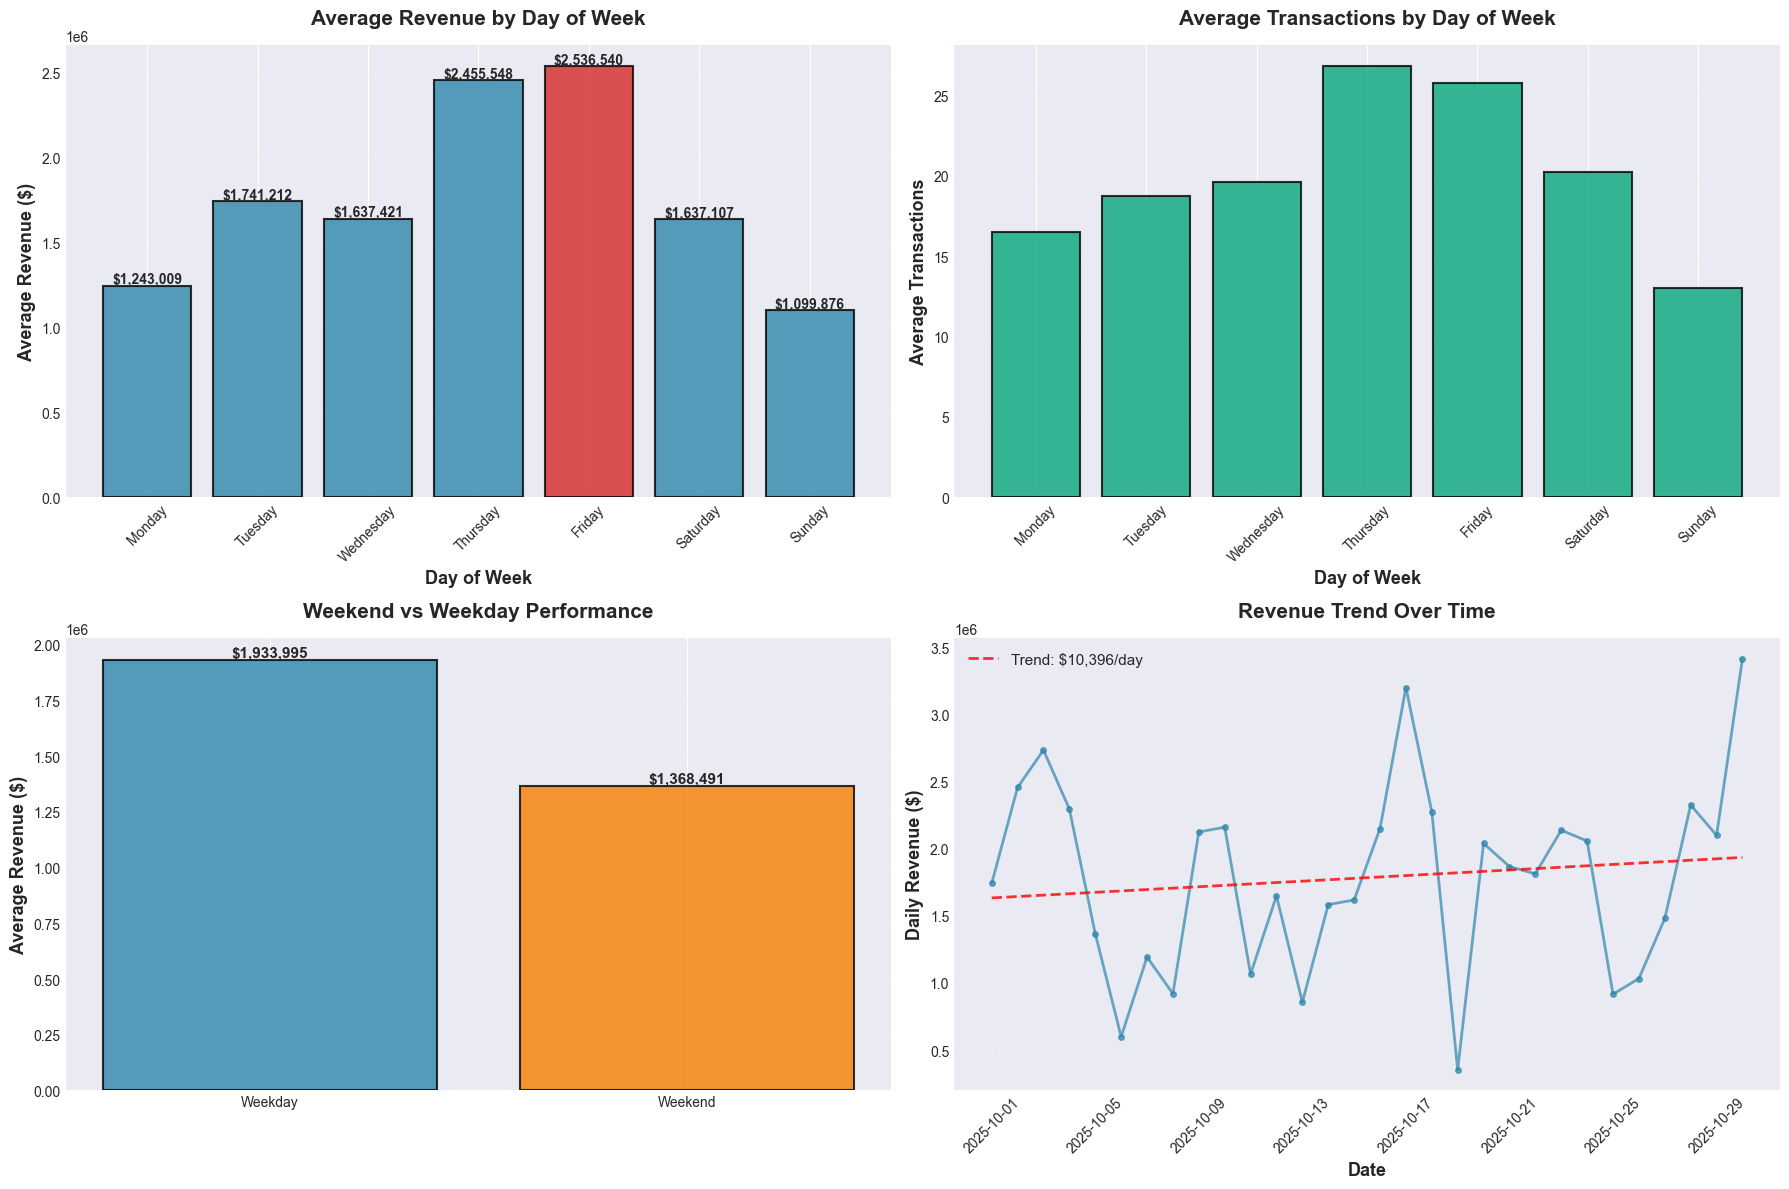

💾 Saved: 03_seasonal_trend_analysis/01_weekly_patterns.png


In [6]:
# Visualization 1: Weekly Performance Dashboard
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))

# Top-left: Daily revenue bar chart
bars = ax1.bar(day_stats['day_of_week'], day_stats['price_total_sum_mean'], 
               color=[COLORS['danger'] if day == best_day else COLORS['primary'] for day in day_stats['day_of_week']],
               edgecolor='black', linewidth=1.5, alpha=0.8)
ax1.set_xlabel('Day of Week', fontsize=13, fontweight='bold')
ax1.set_ylabel('Average Revenue ($)', fontsize=13, fontweight='bold')
ax1.set_title('Average Revenue by Day of Week', fontsize=15, fontweight='bold', pad=15)
ax1.grid(True, alpha=0.3, linestyle=':', axis='y')
ax1.tick_params(axis='x', rotation=45)

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'${height:,.0f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Top-right: Transactions per day
ax2.bar(day_stats['day_of_week'], day_stats['trans_id_count_mean'],
        color=COLORS['success'], edgecolor='black', linewidth=1.5, alpha=0.8)
ax2.set_xlabel('Day of Week', fontsize=13, fontweight='bold')
ax2.set_ylabel('Average Transactions', fontsize=13, fontweight='bold')
ax2.set_title('Average Transactions by Day of Week', fontsize=15, fontweight='bold', pad=15)
ax2.grid(True, alpha=0.3, linestyle=':', axis='y')
ax2.tick_params(axis='x', rotation=45)

# Bottom-left: Weekend vs Weekday
weekend_stats = df_daily.groupby('is_weekend').agg({
    'price_total_sum': 'mean',
    'trans_id_count': 'mean'
})
weekend_labels = ['Weekday', 'Weekend']
ax3.bar(weekend_labels, weekend_stats['price_total_sum'].values,
        color=[COLORS['primary'], COLORS['warning']], edgecolor='black', linewidth=1.5, alpha=0.8)
ax3.set_ylabel('Average Revenue ($)', fontsize=13, fontweight='bold')
ax3.set_title('Weekend vs Weekday Performance', fontsize=15, fontweight='bold', pad=15)
ax3.grid(True, alpha=0.3, linestyle=':', axis='y')

for i, val in enumerate(weekend_stats['price_total_sum'].values):
    ax3.text(i, val, f'${val:,.0f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Bottom-right: Revenue trend line
daily_sorted = df_daily.sort_values('dt_date')
ax4.plot(daily_sorted['dt_date'], daily_sorted['price_total_sum'], 
         color=COLORS['primary'], linewidth=2, marker='o', markersize=4, alpha=0.7)

# Add trend line
z = np.polyfit(range(len(daily_sorted)), daily_sorted['price_total_sum'].values, 1)
p = np.poly1d(z)
ax4.plot(daily_sorted['dt_date'], p(range(len(daily_sorted))), 
         "r--", linewidth=2, label=f'Trend: ${z[0]:,.0f}/day', alpha=0.8)

ax4.set_xlabel('Date', fontsize=13, fontweight='bold')
ax4.set_ylabel('Daily Revenue ($)', fontsize=13, fontweight='bold')
ax4.set_title('Revenue Trend Over Time', fontsize=15, fontweight='bold', pad=15)
ax4.legend(fontsize=11, loc='best')
ax4.grid(True, alpha=0.3, linestyle=':')
ax4.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/01_weekly_patterns.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"💾 Saved: {OUTPUT_DIR}/01_weekly_patterns.png")

## 2. Hourly Patterns Analysis

Identifying peak hours and intraday trends for:
- Optimal staffing schedules
- Inventory replenishment timing
- Marketing campaign scheduling

In [7]:
# Aggregate by hour
hourly_stats = df_hourly.groupby('hour').agg({
    'price_total_sum': ['mean', 'sum', 'std'],
    'trans_id_count': ['mean', 'sum'],
    'quantity_sum': ['mean', 'sum']
}).round(2)

hourly_stats.columns = ['_'.join(col).strip() for col in hourly_stats.columns.values]
hourly_stats = hourly_stats.reset_index().sort_values('hour')

# Define time periods
def get_time_period(hour):
    if 6 <= hour < 12:
        return 'Morning (6-12)'
    elif 12 <= hour < 18:
        return 'Afternoon (12-18)'
    elif 18 <= hour < 24:
        return 'Evening (18-24)'
    else:
        return 'Night (0-6)'

hourly_stats['period'] = hourly_stats['hour'].apply(get_time_period)

# Find peak hours
peak_hour = hourly_stats.loc[hourly_stats['price_total_sum_mean'].idxmax(), 'hour']
peak_revenue = hourly_stats['price_total_sum_mean'].max()
slowest_hour = hourly_stats.loc[hourly_stats['price_total_sum_mean'].idxmin(), 'hour']
slowest_revenue = hourly_stats['price_total_sum_mean'].min()

print("Hourly Performance:")
print("=" * 80)
print(f"   Peak hour: {peak_hour}:00 (${peak_revenue:,.0f} avg revenue)")
print(f"   Slowest hour: {slowest_hour}:00 (${slowest_revenue:,.0f} avg revenue)")
print(f"   Peak/Slowest ratio: {peak_revenue/slowest_revenue:.1f}x")

# Period analysis
period_stats = hourly_stats.groupby('period').agg({
    'price_total_sum_mean': 'mean',
    'trans_id_count_mean': 'mean'
}).round(2)

print(f"\nTime Period Performance:")
for period, row in period_stats.iterrows():
    print(f"   {period:>20}: ${row['price_total_sum_mean']:>10,.0f} avg revenue | {row['trans_id_count_mean']:>5.1f} transactions")

Hourly Performance:
   Peak hour: 14:00 ($301,674 avg revenue)
   Slowest hour: 2:00 ($37,672 avg revenue)
   Peak/Slowest ratio: 8.0x

Time Period Performance:
      Afternoon (12-18): $   200,797 avg revenue |   2.2 transactions
        Evening (18-24): $   100,480 avg revenue |   1.4 transactions
         Morning (6-12): $   155,712 avg revenue |   1.7 transactions
            Night (0-6): $    68,704 avg revenue |   1.0 transactions


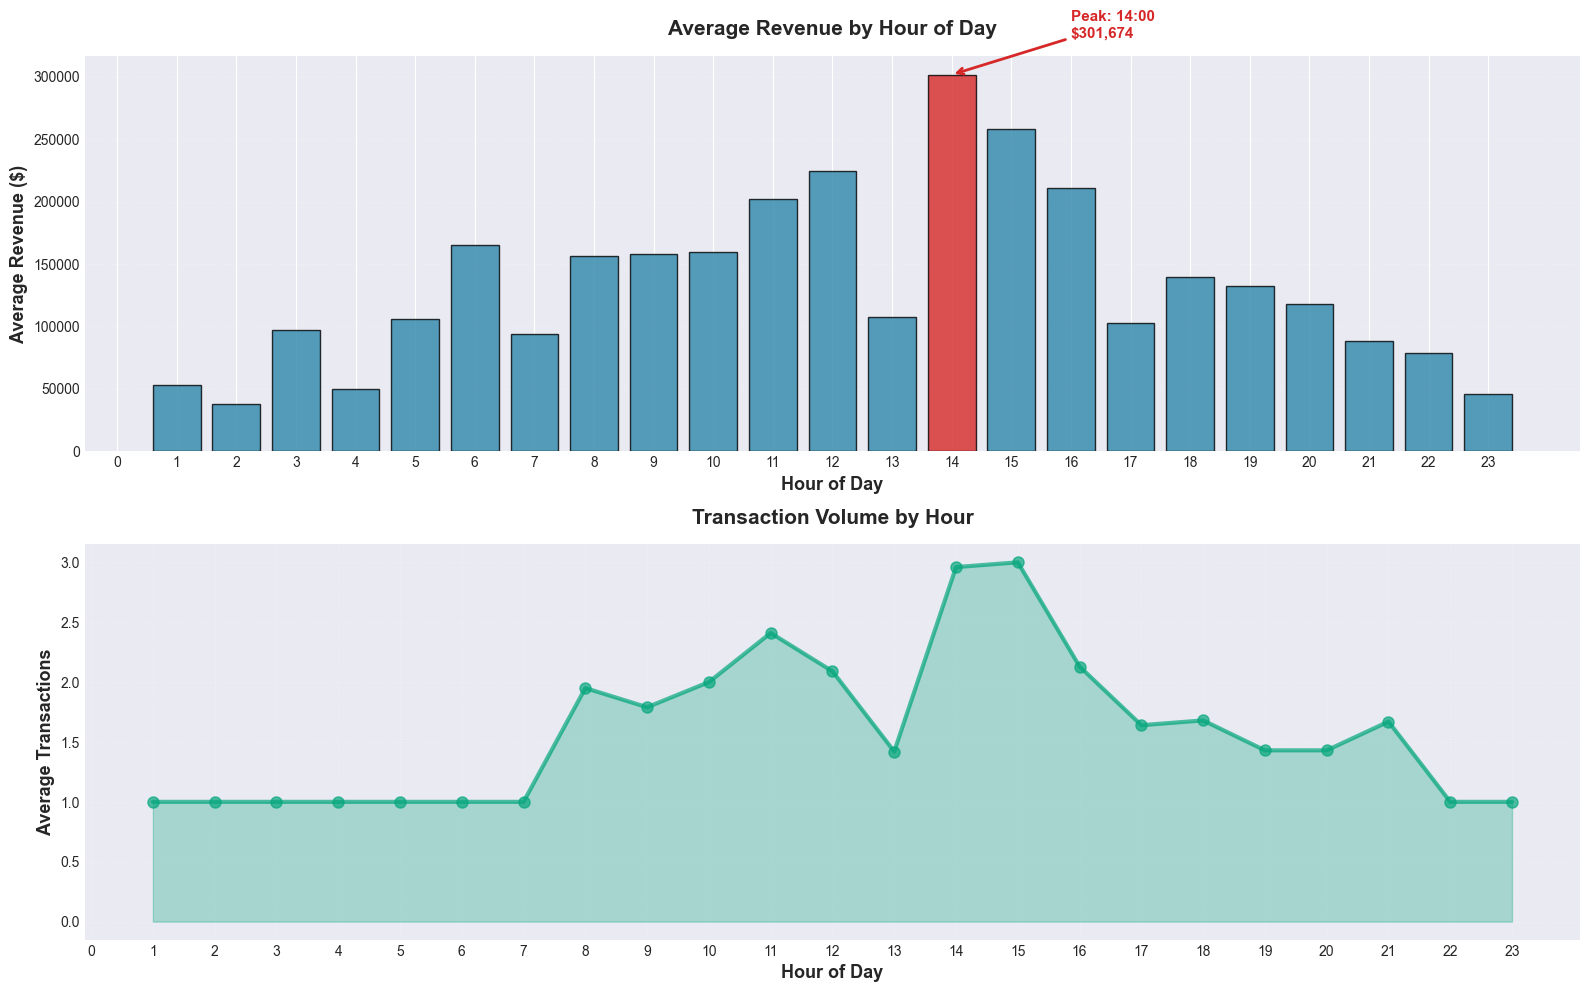

💾 Saved: 03_seasonal_trend_analysis/02_hourly_patterns.png


In [8]:
# Visualization 2: Hourly Patterns
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))

# Top: Hourly revenue pattern
colors = [COLORS['danger'] if h == peak_hour else COLORS['primary'] for h in hourly_stats['hour']]
ax1.bar(hourly_stats['hour'], hourly_stats['price_total_sum_mean'],
        color=colors, edgecolor='black', linewidth=1, alpha=0.8)
ax1.set_xlabel('Hour of Day', fontsize=13, fontweight='bold')
ax1.set_ylabel('Average Revenue ($)', fontsize=13, fontweight='bold')
ax1.set_title('Average Revenue by Hour of Day', fontsize=15, fontweight='bold', pad=15)
ax1.set_xticks(range(0, 24))
ax1.grid(True, alpha=0.3, linestyle=':', axis='y')

# Add peak hour annotation
ax1.annotate(f'Peak: {peak_hour}:00\n${peak_revenue:,.0f}',
            xy=(peak_hour, peak_revenue), xytext=(peak_hour+2, peak_revenue*1.1),
            arrowprops=dict(arrowstyle='->', color=COLORS['danger'], lw=2),
            fontsize=11, fontweight='bold', color=COLORS['danger'])

# Bottom: Transactions by hour
ax2.plot(hourly_stats['hour'], hourly_stats['trans_id_count_mean'],
         color=COLORS['success'], linewidth=3, marker='o', markersize=8, alpha=0.7)
ax2.fill_between(hourly_stats['hour'], hourly_stats['trans_id_count_mean'],
                 alpha=0.3, color=COLORS['success'])
ax2.set_xlabel('Hour of Day', fontsize=13, fontweight='bold')
ax2.set_ylabel('Average Transactions', fontsize=13, fontweight='bold')
ax2.set_title('Transaction Volume by Hour', fontsize=15, fontweight='bold', pad=15)
ax2.set_xticks(range(0, 24))
ax2.grid(True, alpha=0.3, linestyle=':')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/02_hourly_patterns.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"💾 Saved: {OUTPUT_DIR}/02_hourly_patterns.png")

## 3. Time Period Comparison

Comparing performance across different time segments:
- Morning vs Afternoon vs Evening
- Business hours vs After hours
- Strategic implications for operations

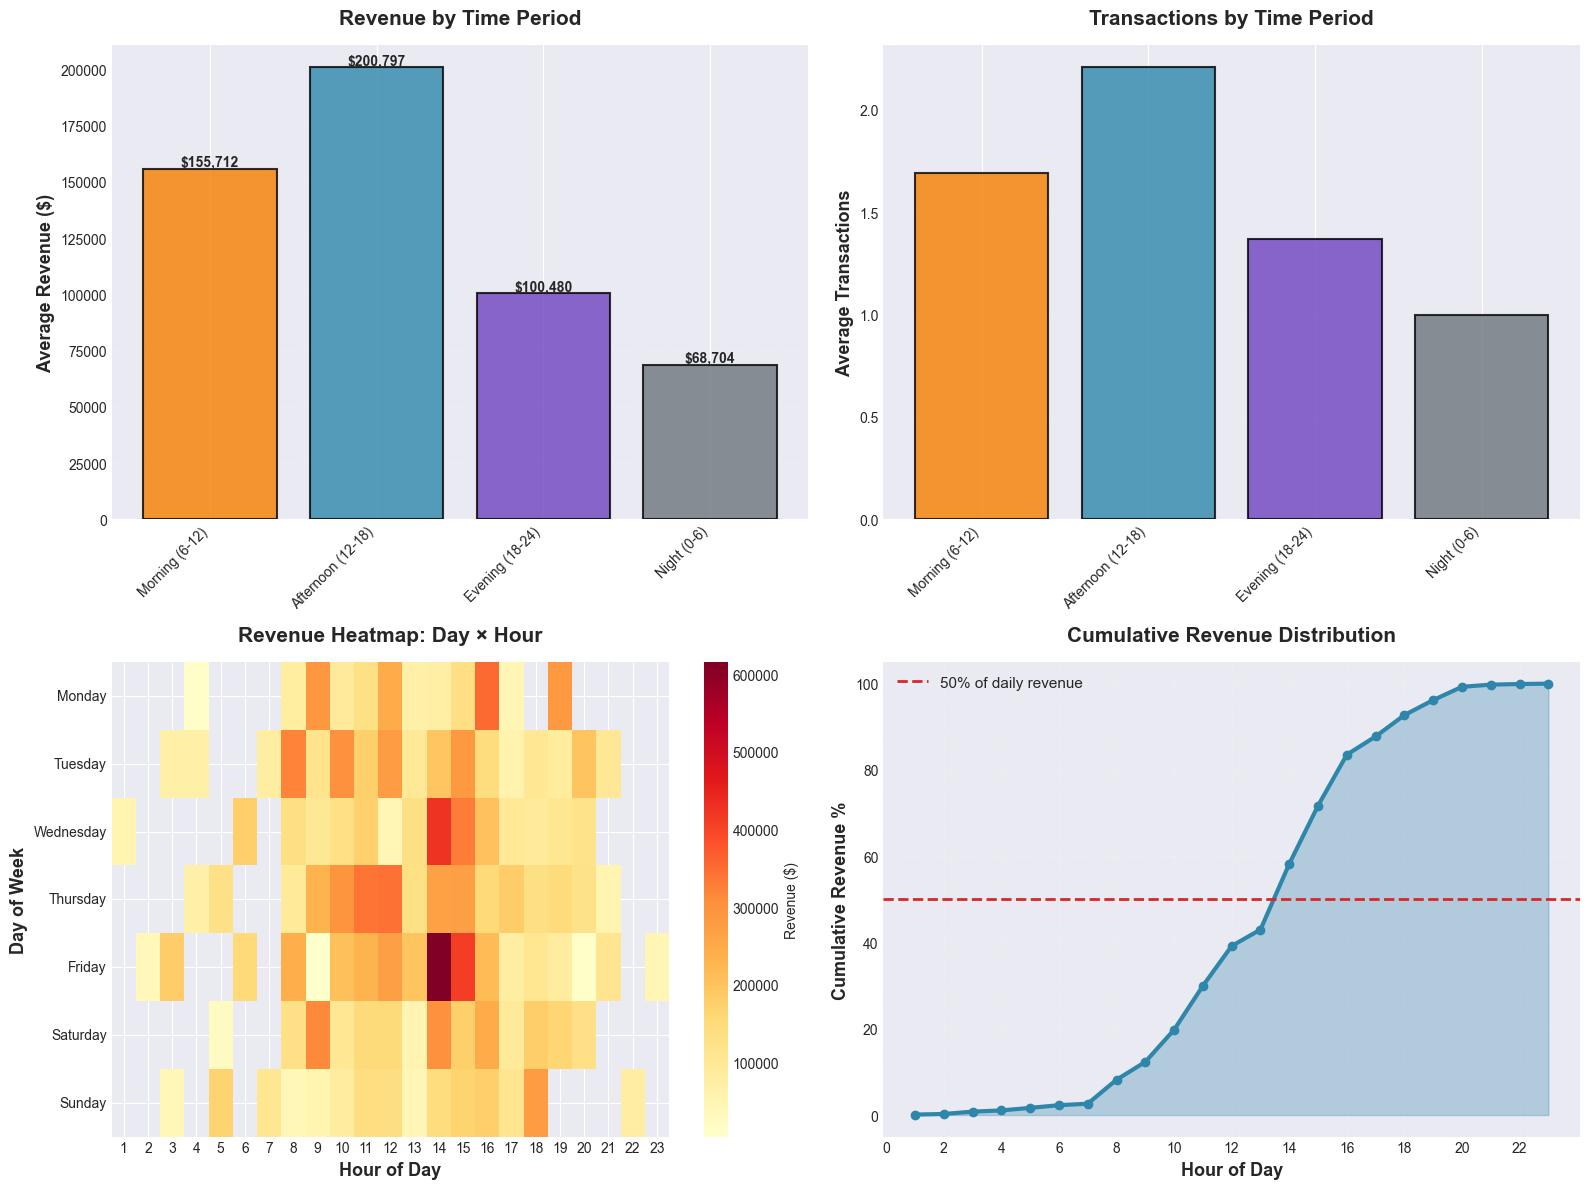

💾 Saved: 03_seasonal_trend_analysis/03_time_period_analysis.png


In [9]:
# Visualization 3: Time Period Analysis
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Period order for consistent display
period_order = ['Morning (6-12)', 'Afternoon (12-18)', 'Evening (18-24)', 'Night (0-6)']
period_colors = [COLORS['warning'], COLORS['primary'], COLORS['purple'], COLORS['secondary']]

# Top-left: Revenue by period
period_revenue = hourly_stats.groupby('period')['price_total_sum_mean'].mean().reindex(period_order)
ax1.bar(range(len(period_order)), period_revenue.values,
        color=period_colors, edgecolor='black', linewidth=1.5, alpha=0.8)
ax1.set_xticks(range(len(period_order)))
ax1.set_xticklabels(period_order, rotation=45, ha='right')
ax1.set_ylabel('Average Revenue ($)', fontsize=13, fontweight='bold')
ax1.set_title('Revenue by Time Period', fontsize=15, fontweight='bold', pad=15)
ax1.grid(True, alpha=0.3, linestyle=':', axis='y')

for i, val in enumerate(period_revenue.values):
    ax1.text(i, val, f'${val:,.0f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Top-right: Transactions by period
period_trans = hourly_stats.groupby('period')['trans_id_count_mean'].mean().reindex(period_order)
ax2.bar(range(len(period_order)), period_trans.values,
        color=period_colors, edgecolor='black', linewidth=1.5, alpha=0.8)
ax2.set_xticks(range(len(period_order)))
ax2.set_xticklabels(period_order, rotation=45, ha='right')
ax2.set_ylabel('Average Transactions', fontsize=13, fontweight='bold')
ax2.set_title('Transactions by Time Period', fontsize=15, fontweight='bold', pad=15)
ax2.grid(True, alpha=0.3, linestyle=':', axis='y')

# Bottom-left: Hourly heatmap
df_daily['day_name'] = df_daily['dt_date'].dt.day_name()
# Create heatmap data by merging daily with hourly
df_hourly['day_name'] = df_hourly['dt_date'].dt.day_name()
heatmap_data = df_hourly.pivot_table(
    values='price_total_sum',
    index='day_name',
    columns='hour',
    aggfunc='mean'
)
heatmap_data = heatmap_data.reindex(day_order)

sns.heatmap(heatmap_data, cmap='YlOrRd', annot=False, fmt='.0f',
            cbar_kws={'label': 'Revenue ($)'}, ax=ax3)
ax3.set_xlabel('Hour of Day', fontsize=13, fontweight='bold')
ax3.set_ylabel('Day of Week', fontsize=13, fontweight='bold')
ax3.set_title('Revenue Heatmap: Day × Hour', fontsize=15, fontweight='bold', pad=15)

# Bottom-right: Cumulative revenue curve
cumulative_revenue = hourly_stats.sort_values('hour')['price_total_sum_sum'].cumsum()
cumulative_pct = (cumulative_revenue / cumulative_revenue.max()) * 100

ax4.plot(hourly_stats.sort_values('hour')['hour'], cumulative_pct,
         color=COLORS['primary'], linewidth=3, marker='o', markersize=6)
ax4.fill_between(hourly_stats.sort_values('hour')['hour'], cumulative_pct,
                 alpha=0.3, color=COLORS['primary'])
ax4.axhline(50, color=COLORS['danger'], linestyle='--', linewidth=2, label='50% of daily revenue')
ax4.set_xlabel('Hour of Day', fontsize=13, fontweight='bold')
ax4.set_ylabel('Cumulative Revenue %', fontsize=13, fontweight='bold')
ax4.set_title('Cumulative Revenue Distribution', fontsize=15, fontweight='bold', pad=15)
ax4.legend(fontsize=11)
ax4.grid(True, alpha=0.3, linestyle=':')
ax4.set_xticks(range(0, 24, 2))

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/03_time_period_analysis.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"💾 Saved: {OUTPUT_DIR}/03_time_period_analysis.png")

## 4. Product Performance by Time

Analyzing which products perform better at different times:
- Product velocity by day of week
- Time-based product recommendations
- Inventory optimization by temporal patterns

In [10]:
# Add day of week to products
df_products['day_of_week'] = df_products['dt_date'].dt.day_name()
df_products['is_weekend'] = df_products['dt_date'].dt.dayofweek.isin([5, 6])

# Product performance by day
product_day_performance = df_products.groupby(['in_product_id', 'day_of_week']).agg({
    'price_total_sum': 'sum',
    'quantity_sum': 'sum'
}).reset_index()

# Find top products per day
print("Top Product by Day of Week:")
print("=" * 80)
for day in day_order:
    day_data = product_day_performance[product_day_performance['day_of_week'] == day]
    if len(day_data) > 0:
        top_product = day_data.loc[day_data['price_total_sum'].idxmax()]
        print(f"{day:>10}: Product {top_product['in_product_id']} (${top_product['price_total_sum']:>10,.0f} | {top_product['quantity_sum']:>4.0f} units)")

# Weekend vs Weekday product performance
product_weekend_performance = df_products.groupby(['in_product_id', 'is_weekend']).agg({
    'price_total_sum': 'sum',
    'quantity_sum': 'sum'
}).reset_index()

print(f"\nWeekend vs Weekday Leaders:")
weekday_leader = product_weekend_performance[product_weekend_performance['is_weekend']==False].nlargest(1, 'price_total_sum')
weekend_leader = product_weekend_performance[product_weekend_performance['is_weekend']==True].nlargest(1, 'price_total_sum')

print(f"   Weekday leader: Product {weekday_leader['in_product_id'].values[0]} (${weekday_leader['price_total_sum'].values[0]:,.0f})")
print(f"   Weekend leader: Product {weekend_leader['in_product_id'].values[0]} (${weekend_leader['price_total_sum'].values[0]:,.0f})")

Top Product by Day of Week:
    Monday: Product prod8 ($ 1,089,845 |   54 units)
   Tuesday: Product prod7 ($ 1,435,529 |   43 units)
 Wednesday: Product prod8 ($ 1,201,059 |   49 units)
  Thursday: Product prod10 ($ 3,534,045 |   89 units)
    Friday: Product prod8 ($ 2,532,863 |   88 units)
  Saturday: Product prod10 ($ 1,467,500 |   37 units)
    Sunday: Product prod8 ($   937,661 |   35 units)

Weekend vs Weekday Leaders:
   Weekday leader: Product prod10 ($7,854,201)
   Weekend leader: Product prod10 ($2,033,265)


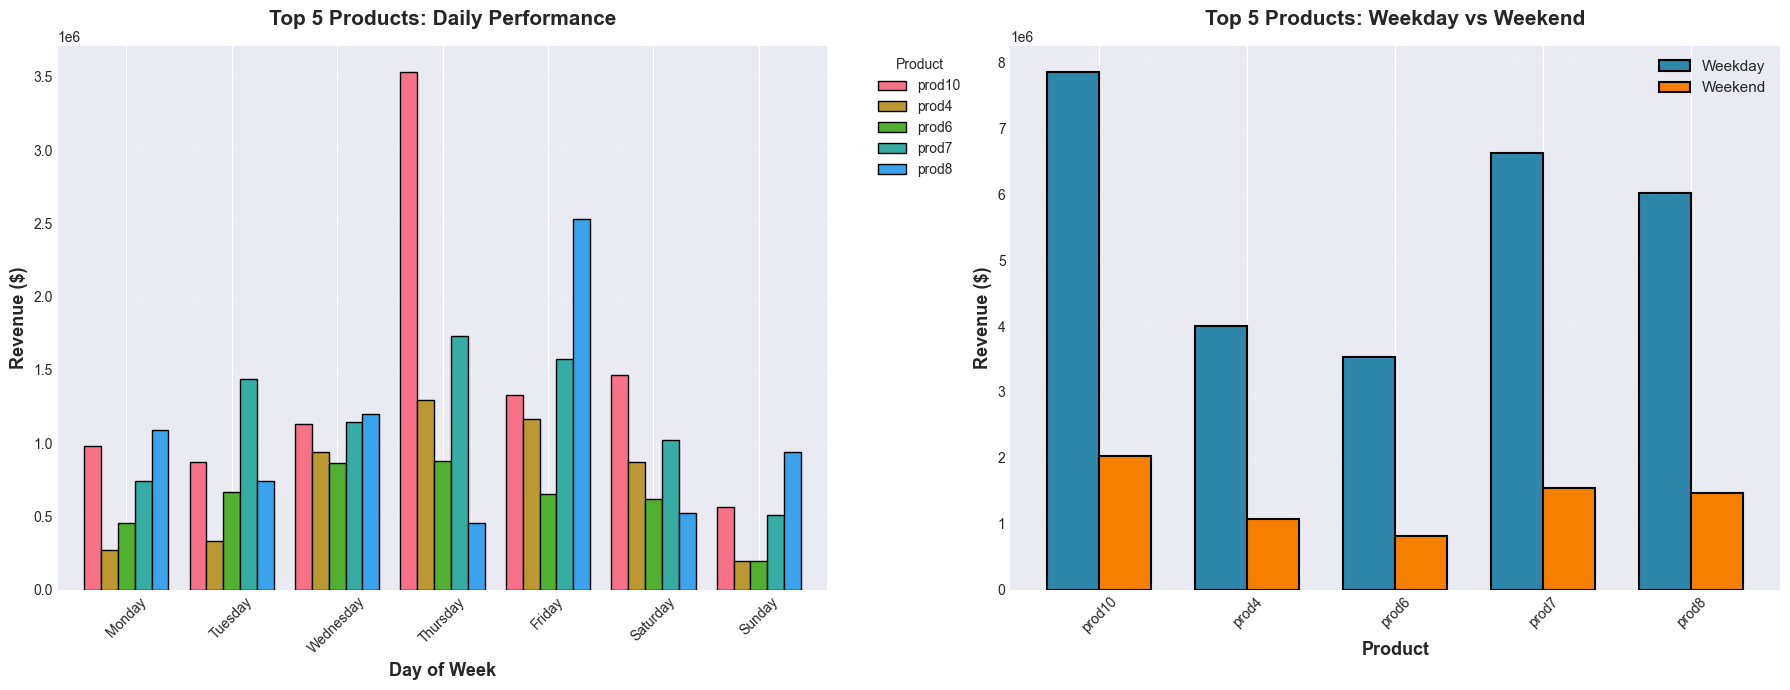

💾 Saved: 03_seasonal_trend_analysis/04_product_time_analysis.png


In [11]:
# Visualization 4: Product Performance by Time
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Left: Top 5 products by day of week
top_products = df_products.groupby('in_product_id')['price_total_sum'].sum().nlargest(5).index
product_day_pivot = product_day_performance[product_day_performance['in_product_id'].isin(top_products)].pivot_table(
    values='price_total_sum',
    index='in_product_id',
    columns='day_of_week'
)[day_order]

product_day_pivot.T.plot(kind='bar', ax=ax1, width=0.8, edgecolor='black', linewidth=1)
ax1.set_xlabel('Day of Week', fontsize=13, fontweight='bold')
ax1.set_ylabel('Revenue ($)', fontsize=13, fontweight='bold')
ax1.set_title('Top 5 Products: Daily Performance', fontsize=15, fontweight='bold', pad=15)
ax1.legend(title='Product', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
ax1.grid(True, alpha=0.3, linestyle=':', axis='y')
ax1.tick_params(axis='x', rotation=45)

# Right: Weekend vs Weekday comparison for top 5
product_weekend_pivot = product_weekend_performance[product_weekend_performance['in_product_id'].isin(top_products)].pivot_table(
    values='price_total_sum',
    index='in_product_id',
    columns='is_weekend'
)
product_weekend_pivot.columns = ['Weekday', 'Weekend']

product_weekend_pivot.plot(kind='bar', ax=ax2, width=0.7,
                           color=[COLORS['primary'], COLORS['warning']],
                           edgecolor='black', linewidth=1.5)
ax2.set_xlabel('Product', fontsize=13, fontweight='bold')
ax2.set_ylabel('Revenue ($)', fontsize=13, fontweight='bold')
ax2.set_title('Top 5 Products: Weekday vs Weekend', fontsize=15, fontweight='bold', pad=15)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3, linestyle=':', axis='y')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/04_product_time_analysis.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"💾 Saved: {OUTPUT_DIR}/04_product_time_analysis.png")

## 5. Trend Analysis & Forecasting

Statistical trend detection and growth patterns:
- Linear trend analysis
- Growth rate calculation
- Volatility assessment
- Forward projections

In [12]:
# Trend analysis
daily_sorted = df_daily.sort_values('dt_date').reset_index(drop=True)
daily_sorted['day_number'] = range(len(daily_sorted))

# Linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(
    daily_sorted['day_number'],
    daily_sorted['price_total_sum']
)

# Calculate metrics
avg_revenue = daily_sorted['price_total_sum'].mean()
growth_rate = (slope / avg_revenue) * 100  # Daily growth rate as %
volatility = (daily_sorted['price_total_sum'].std() / avg_revenue) * 100
trend_strength = r_value ** 2  # R-squared

print("Trend Analysis Results:")
print("=" * 80)
print(f"   Average daily revenue: ${avg_revenue:,.0f}")
print(f"   Daily growth rate: {growth_rate:+.2f}%")
print(f"   Monthly projected growth: {growth_rate * 30:+.1f}%")
print(f"   Revenue volatility: {volatility:.1f}%")
print(f"   Trend strength (R²): {trend_strength:.3f}")
print(f"   Statistical significance: {'Yes' if p_value < 0.05 else 'No'} (p={p_value:.4f})")

# Classify trend
if abs(growth_rate) < 0.5:
    trend_classification = "STABLE"
    trend_color = COLORS['secondary']
elif growth_rate > 0:
    trend_classification = "GROWING"
    trend_color = COLORS['success']
else:
    trend_classification = "DECLINING"
    trend_color = COLORS['danger']

print(f"\n📈 TREND: {trend_classification}")

# Forecast next 7 days
forecast_days = 7
future_day_numbers = range(len(daily_sorted), len(daily_sorted) + forecast_days)
forecast_revenue = [slope * day + intercept for day in future_day_numbers]
forecast_dates = pd.date_range(start=daily_sorted['dt_date'].max() + pd.Timedelta(days=1), periods=forecast_days)

print(f"\n7-Day Forecast (Linear Projection):")
for date, revenue in zip(forecast_dates, forecast_revenue):
    print(f"   {date.strftime('%Y-%m-%d')}: ${revenue:,.0f}")

Trend Analysis Results:
   Average daily revenue: $1,783,194
   Daily growth rate: +0.58%
   Monthly projected growth: +17.5%
   Revenue volatility: 40.5%
   Trend strength (R²): 0.016
   Statistical significance: No (p=0.5051)

📈 TREND: GROWING

7-Day Forecast (Linear Projection):
   2025-10-31: $1,944,327
   2025-11-01: $1,954,723
   2025-11-02: $1,965,119
   2025-11-03: $1,975,515
   2025-11-04: $1,985,910
   2025-11-05: $1,996,306
   2025-11-06: $2,006,702


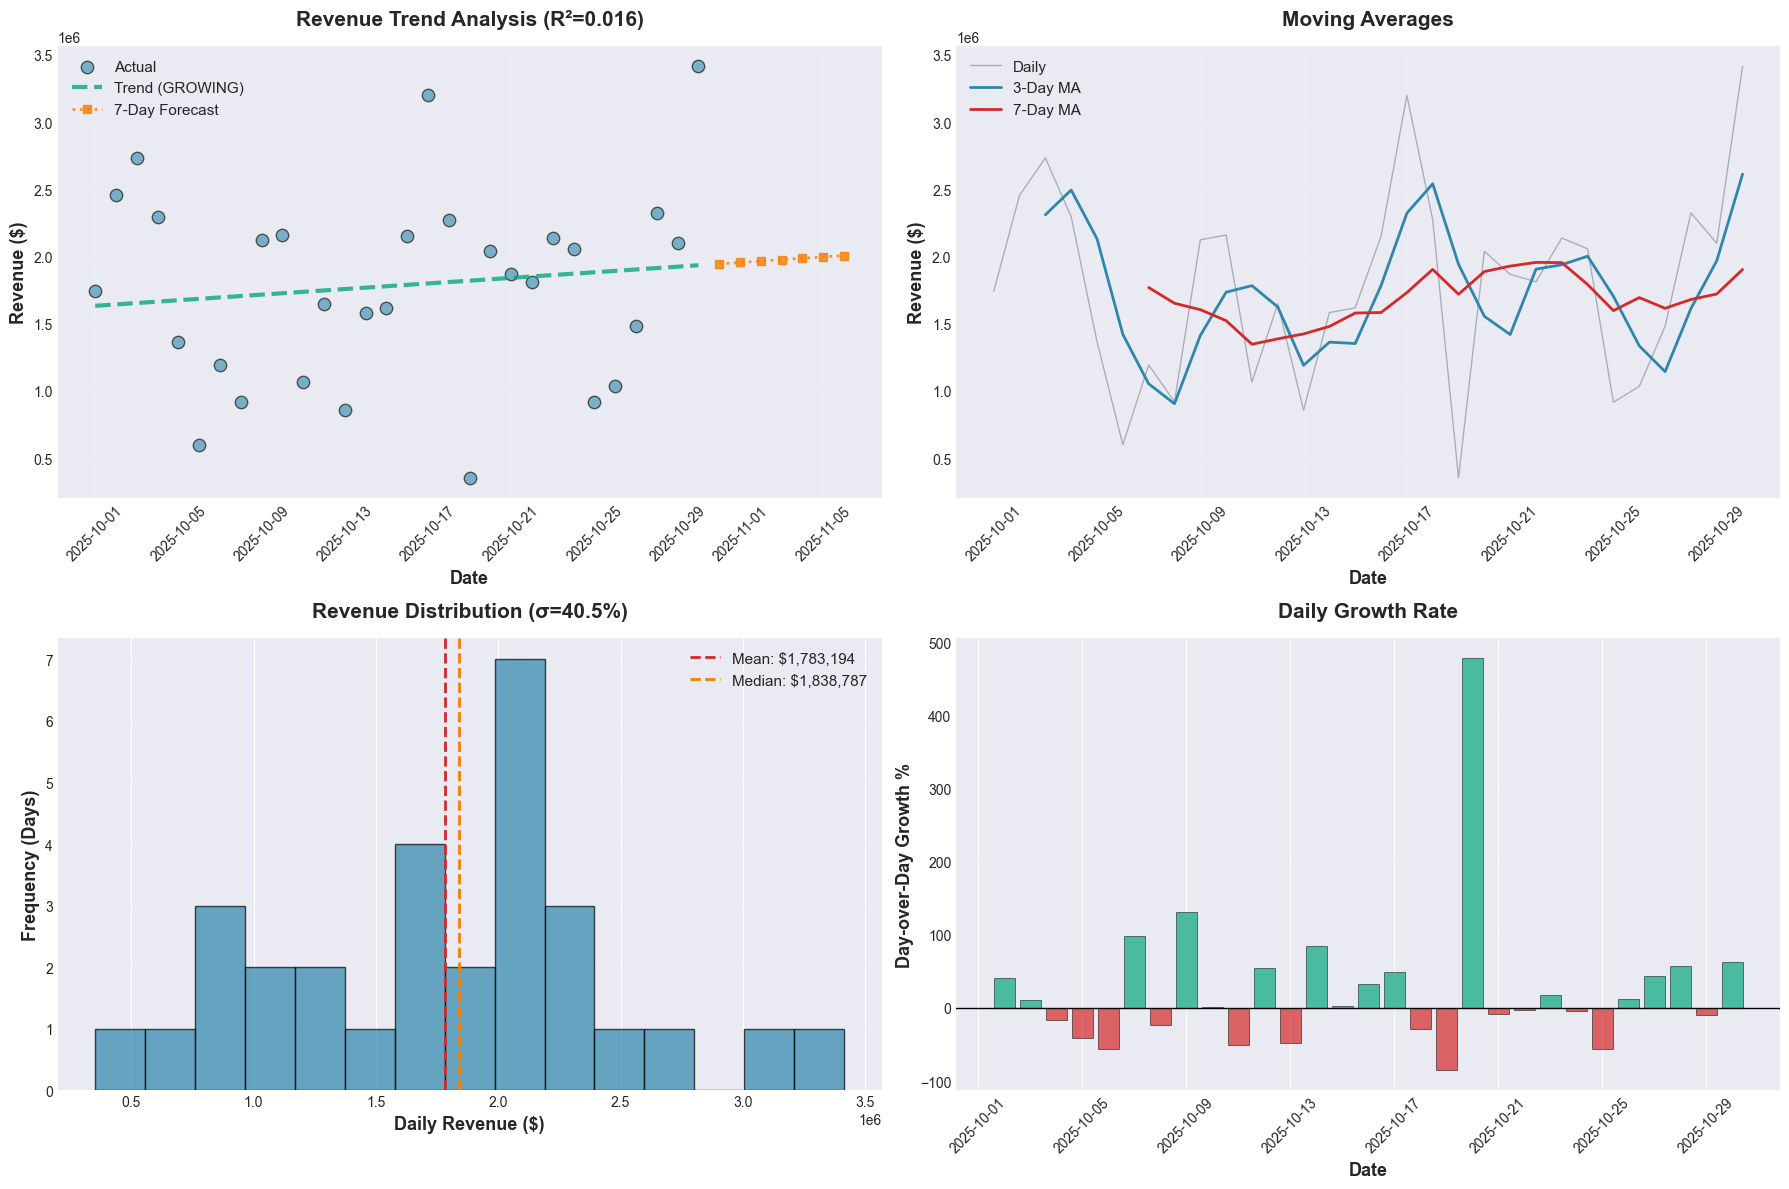

💾 Saved: 03_seasonal_trend_analysis/05_trend_forecast_analysis.png


In [13]:
# Visualization 5: Trend Analysis and Forecast
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))

# Top-left: Revenue with trend line
ax1.scatter(daily_sorted['dt_date'], daily_sorted['price_total_sum'],
           color=COLORS['primary'], s=80, alpha=0.6, edgecolor='black', linewidth=1, label='Actual')
ax1.plot(daily_sorted['dt_date'], slope * daily_sorted['day_number'] + intercept,
        color=trend_color, linewidth=3, linestyle='--', label=f'Trend ({trend_classification})', alpha=0.8)

# Add forecast
ax1.plot(forecast_dates, forecast_revenue,
        color=COLORS['warning'], linewidth=2, linestyle=':', marker='s', markersize=6,
        label='7-Day Forecast', alpha=0.8)

ax1.set_xlabel('Date', fontsize=13, fontweight='bold')
ax1.set_ylabel('Revenue ($)', fontsize=13, fontweight='bold')
ax1.set_title(f'Revenue Trend Analysis (R²={trend_strength:.3f})', fontsize=15, fontweight='bold', pad=15)
ax1.legend(fontsize=11, loc='best')
ax1.grid(True, alpha=0.3, linestyle=':')
ax1.tick_params(axis='x', rotation=45)

# Top-right: Moving averages
daily_sorted['MA3'] = daily_sorted['price_total_sum'].rolling(window=3).mean()
daily_sorted['MA7'] = daily_sorted['price_total_sum'].rolling(window=7).mean()

ax2.plot(daily_sorted['dt_date'], daily_sorted['price_total_sum'],
        color=COLORS['secondary'], linewidth=1, alpha=0.5, label='Daily')
ax2.plot(daily_sorted['dt_date'], daily_sorted['MA3'],
        color=COLORS['primary'], linewidth=2, label='3-Day MA')
ax2.plot(daily_sorted['dt_date'], daily_sorted['MA7'],
        color=COLORS['danger'], linewidth=2, label='7-Day MA')

ax2.set_xlabel('Date', fontsize=13, fontweight='bold')
ax2.set_ylabel('Revenue ($)', fontsize=13, fontweight='bold')
ax2.set_title('Moving Averages', fontsize=15, fontweight='bold', pad=15)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3, linestyle=':')
ax2.tick_params(axis='x', rotation=45)

# Bottom-left: Distribution histogram
ax3.hist(daily_sorted['price_total_sum'], bins=15, color=COLORS['primary'],
        edgecolor='black', alpha=0.7)
ax3.axvline(daily_sorted['price_total_sum'].mean(), color=COLORS['danger'],
           linestyle='--', linewidth=2, label=f"Mean: ${daily_sorted['price_total_sum'].mean():,.0f}")
ax3.axvline(daily_sorted['price_total_sum'].median(), color=COLORS['warning'],
           linestyle='--', linewidth=2, label=f"Median: ${daily_sorted['price_total_sum'].median():,.0f}")

ax3.set_xlabel('Daily Revenue ($)', fontsize=13, fontweight='bold')
ax3.set_ylabel('Frequency (Days)', fontsize=13, fontweight='bold')
ax3.set_title(f'Revenue Distribution (σ={volatility:.1f}%)', fontsize=15, fontweight='bold', pad=15)
ax3.legend(fontsize=11)
ax3.grid(True, alpha=0.3, linestyle=':', axis='y')

# Bottom-right: Growth rate over time
daily_sorted['growth_rate'] = daily_sorted['price_total_sum'].pct_change() * 100
ax4.bar(daily_sorted['dt_date'][1:], daily_sorted['growth_rate'][1:],
       color=[COLORS['success'] if x > 0 else COLORS['danger'] for x in daily_sorted['growth_rate'][1:]],
       edgecolor='black', linewidth=0.5, alpha=0.7)
ax4.axhline(0, color='black', linewidth=1)

ax4.set_xlabel('Date', fontsize=13, fontweight='bold')
ax4.set_ylabel('Day-over-Day Growth %', fontsize=13, fontweight='bold')
ax4.set_title('Daily Growth Rate', fontsize=15, fontweight='bold', pad=15)
ax4.grid(True, alpha=0.3, linestyle=':', axis='y')
ax4.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/05_trend_forecast_analysis.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"💾 Saved: {OUTPUT_DIR}/05_trend_forecast_analysis.png")

## 6. Strategic Recommendations

Actionable insights based on seasonal and trend analysis

In [14]:
print("="*80)
print("STRATEGIC RECOMMENDATIONS: SEASONAL & TREND ANALYSIS")
print("="*80)

print(f"\n🗓️  WEEKLY PATTERNS:")
print(f"   • Best day: {best_day} (${best_revenue:,.0f}) - Maximize staffing and inventory")
print(f"   • Worst day: {worst_day} (${worst_revenue:,.0f}) - Run promotions or reduce costs")
print(f"   • Revenue swing: {revenue_swing:.1f}% - Consider dynamic pricing strategies")

if weekend_stats.loc[True, 'price_total_sum'] > weekend_stats.loc[False, 'price_total_sum']:
    print(f"   • Weekends outperform weekdays - Increase weekend staffing by {((weekend_stats.loc[True, 'price_total_sum']/weekend_stats.loc[False, 'price_total_sum']-1)*100):.0f}%")
else:
    print(f"   • Weekdays outperform weekends - Focus marketing on business hours")

print(f"\n⏰ HOURLY PATTERNS:")
print(f"   • Peak hour: {peak_hour}:00 (${peak_revenue:,.0f}) - Ensure full staffing")
print(f"   • Slowest hour: {slowest_hour}:00 (${slowest_revenue:,.0f}) - Reduce staffing or close")
print(f"   • Peak/Slowest ratio: {peak_revenue/slowest_revenue:.1f}x - High variability requires flexible scheduling")

# Find hour where 50% of revenue is reached
half_revenue_hour = hourly_stats[cumulative_pct >= 50].iloc[0]['hour']
print(f"   • 50% of daily revenue reached by {int(half_revenue_hour)}:00 - Front-load inventory and staff")

print(f"\n📈 TREND ANALYSIS:")
print(f"   • Trend: {trend_classification} ({growth_rate:+.2f}% daily)")
print(f"   • Volatility: {volatility:.1f}% - {'High' if volatility > 20 else 'Moderate' if volatility > 10 else 'Low'} variance in daily revenue")
print(f"   • R²: {trend_strength:.3f} - {'Strong' if trend_strength > 0.7 else 'Moderate' if trend_strength > 0.4 else 'Weak'} trend predictability")

if trend_classification == "GROWING":
    print(f"   • Action: Scale operations to meet growing demand")
    print(f"   • Projected monthly growth: +{growth_rate * 30:.1f}%")
elif trend_classification == "DECLINING":
    print(f"   • Action: Investigate causes and implement corrective measures")
    print(f"   • Projected monthly decline: {growth_rate * 30:.1f}%")
else:
    print(f"   • Action: Maintain current operations, focus on efficiency")

print(f"\n🎯 PRODUCT TIMING:")
print(f"   • Weekday leader: Product {weekday_leader['in_product_id'].values[0]} - Promote during business week")
print(f"   • Weekend leader: Product {weekend_leader['in_product_id'].values[0]} - Feature in weekend campaigns")
print(f"   • Consider time-based inventory allocation based on product-day performance")

print(f"\n💡 OPERATIONAL INSIGHTS:")
best_period = period_revenue.idxmax()
print(f"   • Best time period: {best_period} (${period_revenue.max():,.0f} avg)")
print(f"   • Schedule key operations (deliveries, restocking) during low-traffic periods")
print(f"   • Use slow days ({worst_day}) for maintenance, training, and planning")
print(f"   • Implement flash sales during slow hours ({slowest_hour}:00) to boost traffic")

print("\n" + "="*80)

STRATEGIC RECOMMENDATIONS: SEASONAL & TREND ANALYSIS

🗓️  WEEKLY PATTERNS:
   • Best day: Friday ($2,536,540) - Maximize staffing and inventory
   • Worst day: Sunday ($1,099,876) - Run promotions or reduce costs
   • Revenue swing: 130.6% - Consider dynamic pricing strategies
   • Weekdays outperform weekends - Focus marketing on business hours

⏰ HOURLY PATTERNS:
   • Peak hour: 14:00 ($301,674) - Ensure full staffing
   • Slowest hour: 2:00 ($37,672) - Reduce staffing or close
   • Peak/Slowest ratio: 8.0x - High variability requires flexible scheduling
   • 50% of daily revenue reached by 14:00 - Front-load inventory and staff

📈 TREND ANALYSIS:
   • Trend: GROWING (+0.58% daily)
   • Volatility: 40.5% - High variance in daily revenue
   • R²: 0.016 - Weak trend predictability
   • Action: Scale operations to meet growing demand
   • Projected monthly growth: +17.5%

🎯 PRODUCT TIMING:
   • Weekday leader: Product prod10 - Promote during business week
   • Weekend leader: Product pr

In [15]:
print("\n✅ SEASONAL TREND ANALYSIS COMPLETE!")
print(f"\nAll visualizations saved to: {OUTPUT_DIR}/")
print("  1. 01_weekly_patterns.png")
print("  2. 02_hourly_patterns.png")
print("  3. 03_time_period_analysis.png")
print("  4. 04_product_time_analysis.png")
print("  5. 05_trend_forecast_analysis.png")
print("\n📊 Key Insights:")
print(f"  • Revenue trend: {trend_classification} ({growth_rate:+.2f}% daily)")
print(f"  • Best day: {best_day} (${best_revenue:,.0f})")
print(f"  • Peak hour: {peak_hour}:00 (${peak_revenue:,.0f})")
print(f"  • Volatility: {volatility:.1f}%")
print(f"  • 7-day forecast: ${sum(forecast_revenue):,.0f} total revenue")


✅ SEASONAL TREND ANALYSIS COMPLETE!

All visualizations saved to: 03_seasonal_trend_analysis/
  1. 01_weekly_patterns.png
  2. 02_hourly_patterns.png
  3. 03_time_period_analysis.png
  4. 04_product_time_analysis.png
  5. 05_trend_forecast_analysis.png

📊 Key Insights:
  • Revenue trend: GROWING (+0.58% daily)
  • Best day: Friday ($2,536,540)
  • Peak hour: 14:00 ($301,674)
  • Volatility: 40.5%
  • 7-day forecast: $13,828,602 total revenue
